In [1]:
%%html
<style>
.CodeMirror pre, .CodeMirror-dialog, .CodeMirror-dialog .CodeMirror-search-field, .terminal-app .terminal {
    font-family: "Courier New", Courier, monospace;
    font-size: 12pt;
}
</style> 

In [2]:
# Code from Ben Fraser's article in Medium. Implementing a single layer neural network 
# using the Adaline algorithm, which adjusts the weights based on the weighted sum of
# the input function. The original algorithm was proposed in the 1960's for implementing
# a single layer neural network.
# This is a bare-bones neural layer which only uses the numpy library, everything is 
# built from scratch

# https://medium.com/@benjamindavidfraser/understanding-basic-machine-learning-with-python-perceptrons-and-artificial-neurons-dfae8fe61700
# Ben Fraser, Medium, 7 Jul 2018

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()

In [3]:
# This class implements a single perceptron, in the original code posted on Medium, this
# class was run as a standalone file. I've combined them here to have everything run
# from a single notebook and then used the class directly without an import
class PerceptronBirds(object):
    """ Perceptron for demonstrating a binary classifier """

    def __init__(self, learn_rate=0.01, iterations=100):
        self.learn_rate = learn_rate
        self.iterations = iterations

    def fit(self, X, y, biased_X=False):
        """ Fit training data to our model """
        X = self._add_bias(X)
        self._initialise_weights(X)

        self.errors = []

        for cycle in range(self.iterations):
            trg_error = 0
            for x_i, output in zip(X, y):
                output_pred = self.predict(x_i, biased_X=True)
                trg_update = self.learn_rate * (output - output_pred)
                self.weights += trg_update * x_i
                trg_error += int(trg_update != 0.0)
            self.errors.append(trg_error)
        return self

    def _net_input(self, X):
        """ Net input function (weighted sum) """
        return np.dot(X, self.weights)

    def predict(self, X, biased_X=False):
        """ Make predictions for the given data, X, using unit step function """
        if not biased_X:
            X = self._add_bias(X)
        return np.where(self._net_input(X) >= 0.0, 1, 0)

    def _add_bias(self, X):
        """ Add a bias column of 1's to our data, X """
        bias = np.ones((X.shape[0], 1))
        biased_X = np.hstack((bias, X))
        return biased_X

    def _initialise_weights(self, X):
        """ Initialise weigths - normal distribution sample with standard dev 0.01 """
        random_gen = np.random.RandomState(1)
        self.weights = random_gen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        return self

    def confusion_matrix(self, con_inputs, con_targets, verbose=False):
        # Add the inputs that match the bias node
        self.n_data = np.shape(con_inputs)[0]
        con_inputs = np.concatenate((con_inputs, -np.ones((self.n_data, 1))), axis=1)
        con_outputs = np.dot(con_inputs, self.weights)
        num_classes = np.shape(con_targets)[1]

        if num_classes == 1:
            num_classes = 2
            con_outputs = np.where(con_outputs > 0, 1, 0)
        else:
            # 1 of N encoding
            con_outputs = np.argmax(con_outputs, 1)
            con_targets = np.argmax(con_targets, 1)

        conf_mat = np.zeros((num_classes, num_classes))
        for i in range(num_classes):
            for j in range(num_classes):
                conf_mat[i, j] = np.sum(np.where(con_outputs == i, 1, 0) * np.where(con_targets == j, 1, 0))

        print(conf_mat)
        print(np.trace(conf_mat) / np.sum(conf_mat))
        print("----------------------------------------------")

        return con_outputs

In [4]:
# Adaline introduces a much smoother gradient descent based cost function instead of the very abrupt step change function found in the Perceptron algorithm
class AdalineBirds(object):
    """ Adaline (Adaptive Linear Neuron) for binary classification.
        Minimises the cost function using gradient descent. """

    def __init__(self, learn_rate=0.01, iterations=100):
        self.learn_rate = learn_rate
        self.iterations = iterations

    def fit(self, X, y, biased_X=False, standardised_X=False):
        """ Fit training data to our model """
        if not standardised_X:
            X = self._standardise_features(X)
        if not biased_X:
            X = self._add_bias(X)
        self._initialise_weights(X)
        self.cost = []

        for cycle in range(self.iterations):
            output_pred = self._activation(self._net_input(X))
            errors = y - output_pred

            self.weights += (self.learn_rate * X.T.dot(errors))
            cost = (errors ** 2).sum() / 2.0
            self.cost.append(cost)
        return self

    def _net_input(self, X):
        """ Net input function (weighted sum) """
        return np.dot(X, self.weights)

    def predict(self, X, biased_X=False):
        """ Make predictions for the given data, X, using unit step function """
        if not biased_X:
            X = self._add_bias(X)
        return np.where(self._activation(self._net_input(X)) >= 0.0, 1, 0)

    def _add_bias(self, X):
        """ Add a bias column of 1's to our data, X """
        bias = np.ones((X.shape[0], 1))
        biased_X = np.hstack((bias, X))
        return biased_X

    def _initialise_weights(self, X):
        """ Initialise weigths - normal distribution sample with standard dev 0.01 """
        random_gen = np.random.RandomState(1)
        self.weights = random_gen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        return self

    def _standardise_features(self, X):
        """ Standardise our input features with zero mean and standard dev of 1 """
        X_norm = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
        return X_norm

    def _activation(self, X):
        """ Linear activation function - simply returns X """
        return X

    def confusion_matrix(self, con_inputs, con_targets, verbose=False):
        # Add the inputs that match the bias node
        self.n_data = np.shape(con_inputs)[0]
        con_inputs = np.concatenate((con_inputs, -np.ones((self.n_data, 1))), axis=1)

        con_outputs = np.dot(con_inputs, self.weights)
        num_classes = np.shape(con_targets)[1]

        if num_classes == 1:
            num_classes = 2
            con_outputs = np.where(con_outputs > 0, 1, 0)
        else:
            # 1 of N encoding
            con_outputs = np.argmax(con_outputs, 1)
            con_targets = np.argmax(con_targets, 1)

        conf_mat = np.zeros((num_classes, num_classes))
        for i in range(num_classes):
            for j in range(num_classes):
                conf_mat[i, j] = np.sum(np.where(con_outputs == i, 1, 0) * np.where(con_targets == j, 1, 0))

        print(conf_mat)
        print(np.trace(conf_mat) / np.sum(conf_mat))
        print("----------------------------------------------")

        return con_outputs

In [5]:
# make up random data for bird wingspans and weights for golden eagles and horned owls
np.random.seed(100)
bird_wingspans = np.concatenate([np.random.randint(170, 230, size = 50)/100.0, 
                                 np.random.randint(60, 100, size = 50)/100.0])
bird_weights = np.concatenate([(11 - 10)*np.random.randn(50)+10, np.abs(np.random.randn(50))+1])

# combine X vectors into a 2-dimensional array with 100 rows and 2 columns
X = np.vstack((bird_wingspans, bird_weights)).T

# create labels for our input data - first 50 are Golden Eagles (binary 0), last 50 are Horned Owls (binary 1)
y = np.concatenate([np.zeros(50), np.ones(50)])

# confirm shapes of generated data
print("The shape of our input matrix, X, is: {0}.".format(X.shape))
print("The shape of our output vector, y, is: {0}.".format(y.shape))

The shape of our input matrix, X, is: (100, 2).
The shape of our output vector, y, is: (100,).


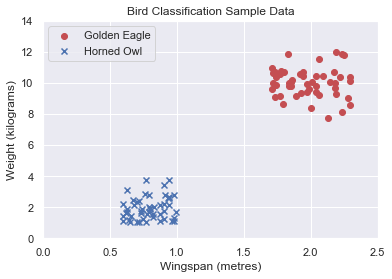

In [6]:
# plot our data on a scatter graph using matplotlib
# first 50 samples = Golden Eagle - plot both input features (columns 0 and 1 of X)
plt.scatter(X[:50, 0], X[:50, 1], color='r', marker='o', label='Golden Eagle')
# last 50 samples = Horned Owls
plt.scatter(X[50:, 0], X[50:, 1], color='b', marker='x', label = "Horned Owl")
plt.title("Bird Classification Sample Data")
plt.xlabel("Wingspan (metres)")
plt.ylabel("Weight (kilograms)")
plt.legend(loc = 'upper left')
plt.xlim([0, 2.5])
plt.ylim([0, 14])
plt.show()

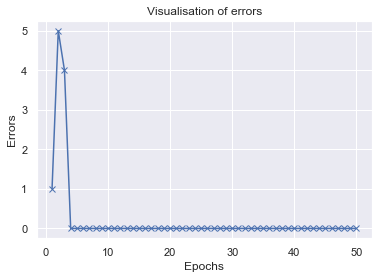

In [7]:
# create a perceptron classifier and train on our data
classifier = PerceptronBirds(learn_rate = 0.1, iterations = 50)
classifier.fit(X, y)

# plot our misclassification error after each iteration of training
plt.plot(range(1, len(classifier.errors) + 1), classifier.errors, marker = 'x')
plt.title("Visualisation of errors")
plt.xlabel('Epochs')
plt.ylabel('Errors')
plt.show()

In [8]:
# create a perceptron classifier and train on our data
classifier = AdalineBirds(learn_rate = 0.001, iterations = 50)
classifier.fit(X, y)

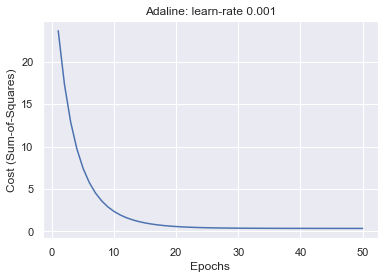

In [9]:
# plot our misclassification error after each iteration of training
plt.plot(range(1, len(classifier.cost) + 1), classifier.cost)
plt.title("Adaline: learn-rate 0.001")
plt.xlabel('Epochs')
plt.ylabel('Cost (Sum-of-Squares)')
plt.show()